### Time to get your hands dirty.  The transient Universe 2


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [1]:
# LECTURE 12 -> MCMC: NESTED SAMPLING ALGORITHM
# TRANSIENT UNIVERSE: Transient phenomena include Tidal distruption events, Sudden flares of active galactic nuclei and Supernovae.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import corner
import dynesty
from dynesty import NestedSampler
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

# (100x3) numpy array containing some time-series measurements from a transient phenomenon. Data in arbitrary units
# 1 column: TIME
# 2 column: FLUX
# 3 column: FLUX HOMOESCEDASTIC UNCERTAINTIES

data = np.load("transient.npy") # returns a matrix

TIME = data[:, 0]
FLUX = data[:, 1]
Sflux = data[:, 2]

7949it [00:21, 371.26it/s, +500 | bound: 48 | nc: 1 | ncall: 55519 | eff(%): 15.357 | loglstar:   -inf < -140.650 <    inf | logz: -155.768 +/-  0.172 | dlogz:  0.001 >  0.509]


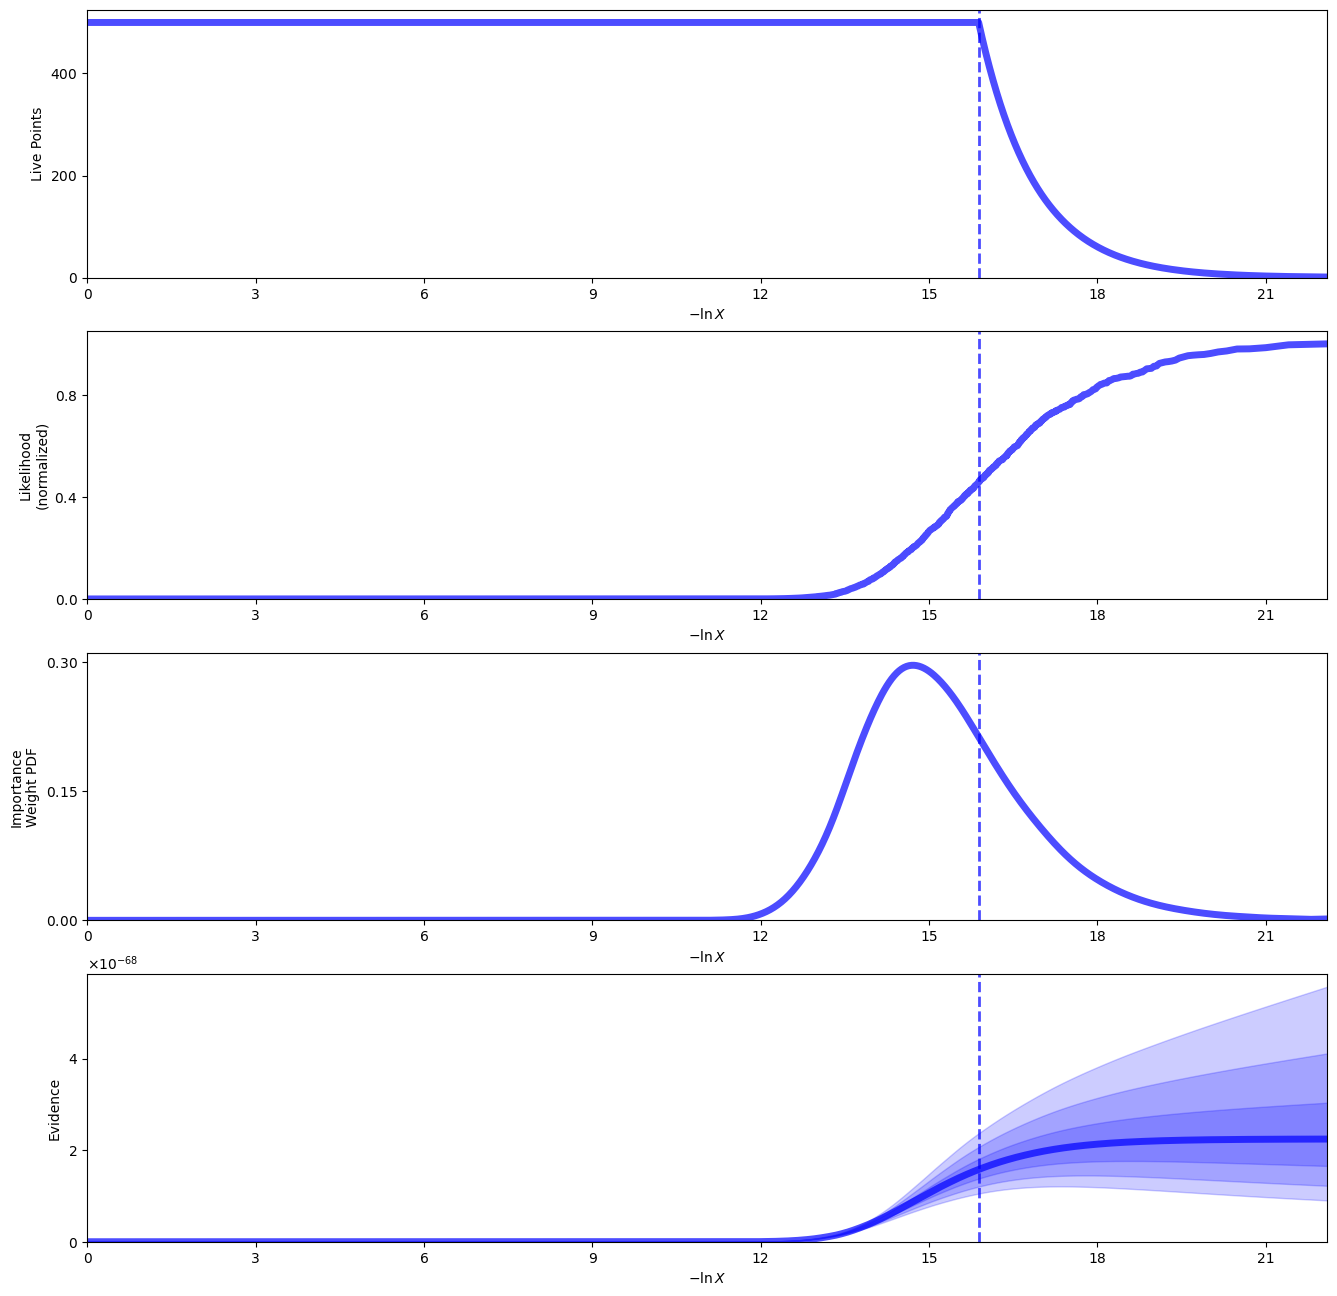

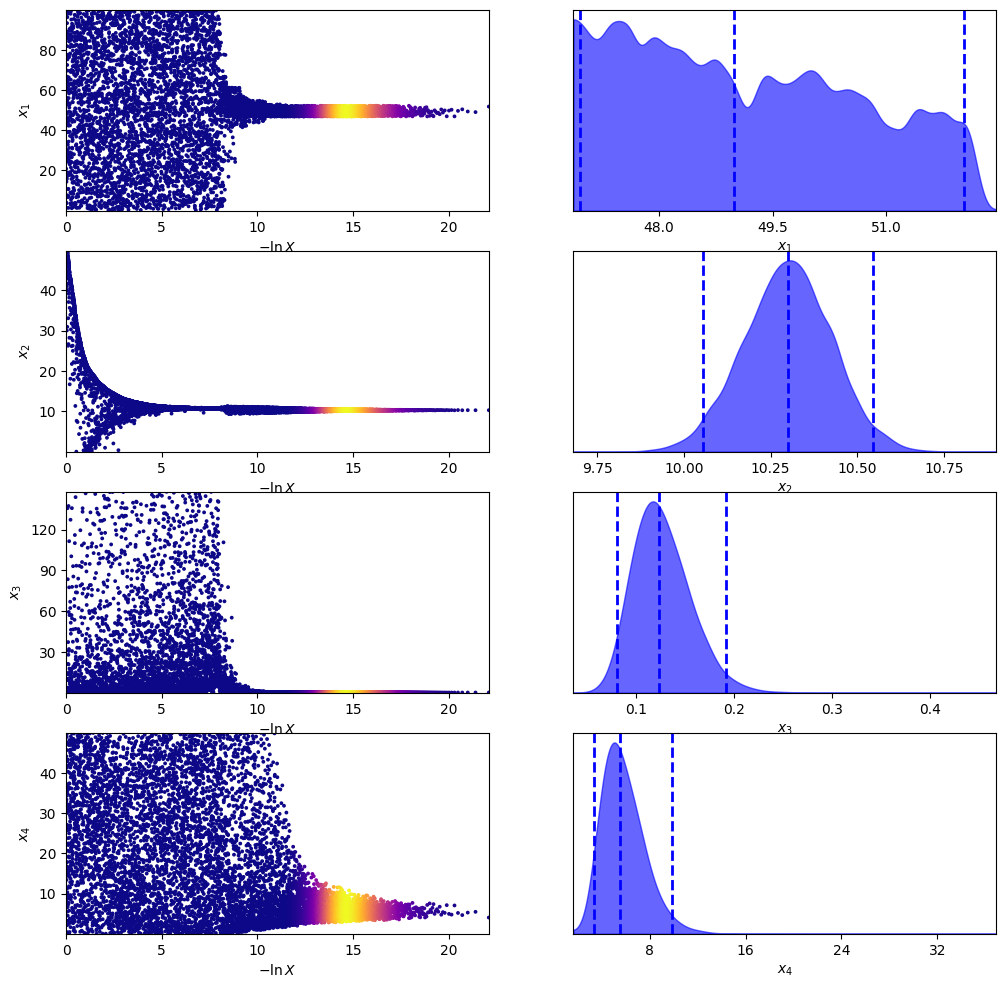

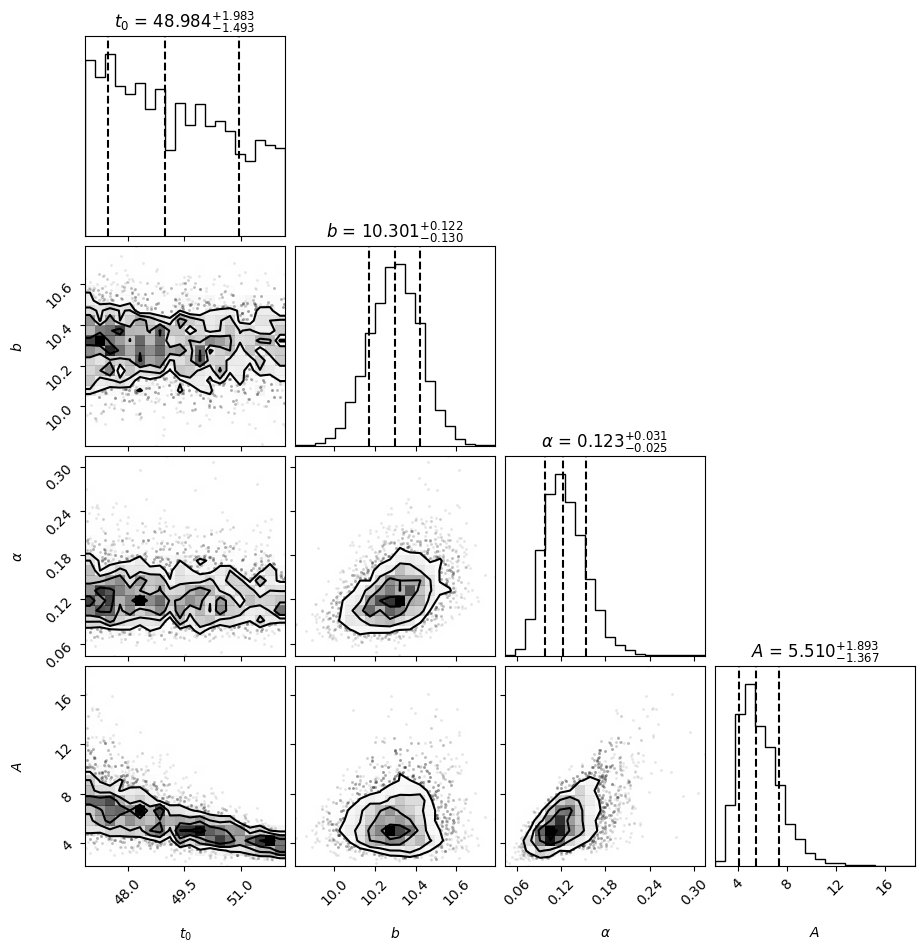

In [ ]:
# >> MODEL 1
# MODEL is a sharp burst with an exponential tail rising above a nominal background level -> 4 PARAMETERS
ndim = 4 

def burst1 (TIME, t0, b, alfa, A): # t0=time of burst | alfa=rapidity of burst die off | A=amplitude 
    y = np.zeros(len(TIME))
    
    for i in range(len(TIME)):
        if TIME[i] < t0:
            y[i] = b
        else: 
            y[i] = b + A * np.exp(-alfa * (TIME[i]-t0))
    
    return y

# LOG-LIKELIHOOD for the model -> NORMALISED so that I can calculate the Bayesian evidence
# defined to be dynesty friendly: parameters given as an array + data given as globals arguments
def LOGlikelihood1(TIME, FLUX, Sflux):
    def loglike(theta):
        t0, b, alfa, A = theta
        model = burst1(TIME, t0, b, alfa, A)
        normaliz = np.log(2 * np.pi * Sflux ** 2) # logarithmic normalization of the normal distribution
        return -0.5 * np.sum(((FLUX - model) / Sflux) ** 2 + normaliz)
    return loglike

# PRIOR FUNCTIONS -> prior transform: maps samples from  a unit cube [0,1]^ndim to the real parameter space of a model
def prior_transform(u):
    t0 = 0 + 100 * u[0]       
    b = 0 + 50 * u[1]           
    A = 0 + 50 * u[2]            
    alfa = np.exp(-5 + 10 * u[3]) # Log-uniform between exp(-5) e exp(5)
    return [t0, b, alfa, A]
    
# > DYNESTY
# dynesty estimates the evidence and the posterior integrating the product of the prior and the log_likelihood 
# X: prior volume: starts from 1 goes to 0 as the we climb the L

# Evidence of a likelihood contour: delta(Z) = sum of L(lowest) * delta(X) 

loglike = LOGlikelihood1(TIME, FLUX, Sflux) # sampling function

sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=4, nlive=500, bootstrap=0) # sampler initialization
sampler.run_nested()

results = sampler.results

# Plot a summary of the run: X: [0, 1] -> -logX: [0, inf] (small X -> inf)
rfig, raxes = dyplot.runplot(results)
tfig, taxes = dyplot.traceplot(results)

# normal weights -> obtain means and variances representative of the posterior distribution, not of the sampling
samples = results.samples # results.samples = sampled parameters (N, ndim)
weights = np.exp(results.logwt - results.logz[-1]) # normalised weights = exp (log_weights) / exp (log_bayesian_evidence)
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resampling of points to obtain same distribution and same weight
resampled = dyfunc.resample_equal(samples, weights)

# Corner plot of the 4-D parameter space, with labels, [68, 95] credible levels and quantiles, and titles
labels = [r"$t_0$", r"$b$", r"$\alpha$", r"$A$"]

fig = corner.corner( # CAN'T USE DIFFERENT WEIGHTS
    resampled,
    labels=labels,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)

plt.show()

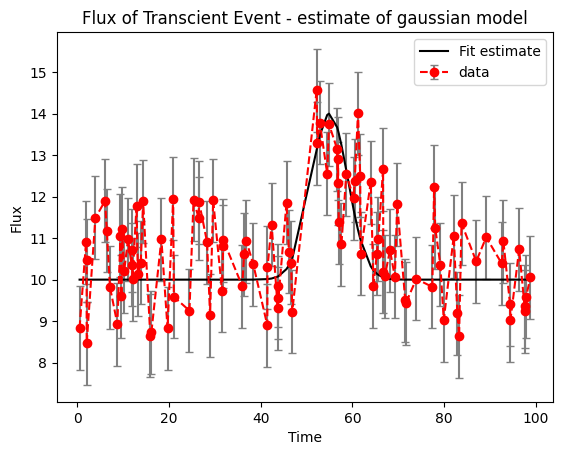

6078it [00:26, 229.25it/s, +900 | bound: 22 | nc: 1 | ncall: 103045 | eff(%):  6.831 | loglstar:   -inf < -144.310 <    inf | logz: -150.958 +/-  0.093 | dlogz:  0.001 >  0.909]



model_1
t0 = 49.18051215182186 - b = 10.298663879361726 - alpha = 0.12628842427464773 - A = 5.798180966646601
Posterior covariance: 
[[ 2.29516187e+00 -3.36525526e-03 -1.98345460e-03 -1.73748930e+00]
 [-3.36525526e-03  1.56255770e-02  1.41012980e-03  1.81592700e-02]
 [-1.98345460e-03  1.41012980e-03  8.31693610e-04  2.95418934e-02]
 [-1.73748930e+00  1.81592700e-02  2.95418934e-02  2.93208385e+00]]

model_2
t0 = 55.421583885979445 - b = 10.315073561493094 - sigma = 5.303566259633894 - A = 2.7688888385119275
Posterior covariance: 
[[ 0.98199241 -0.02111328  0.24203224 -0.11123176]
 [-0.02111328  0.01456322 -0.03665736 -0.00949181]
 [ 0.24203224 -0.03665736  0.59792047 -0.10459224]
 [-0.11123176 -0.00949181 -0.10459224  0.13361196]]


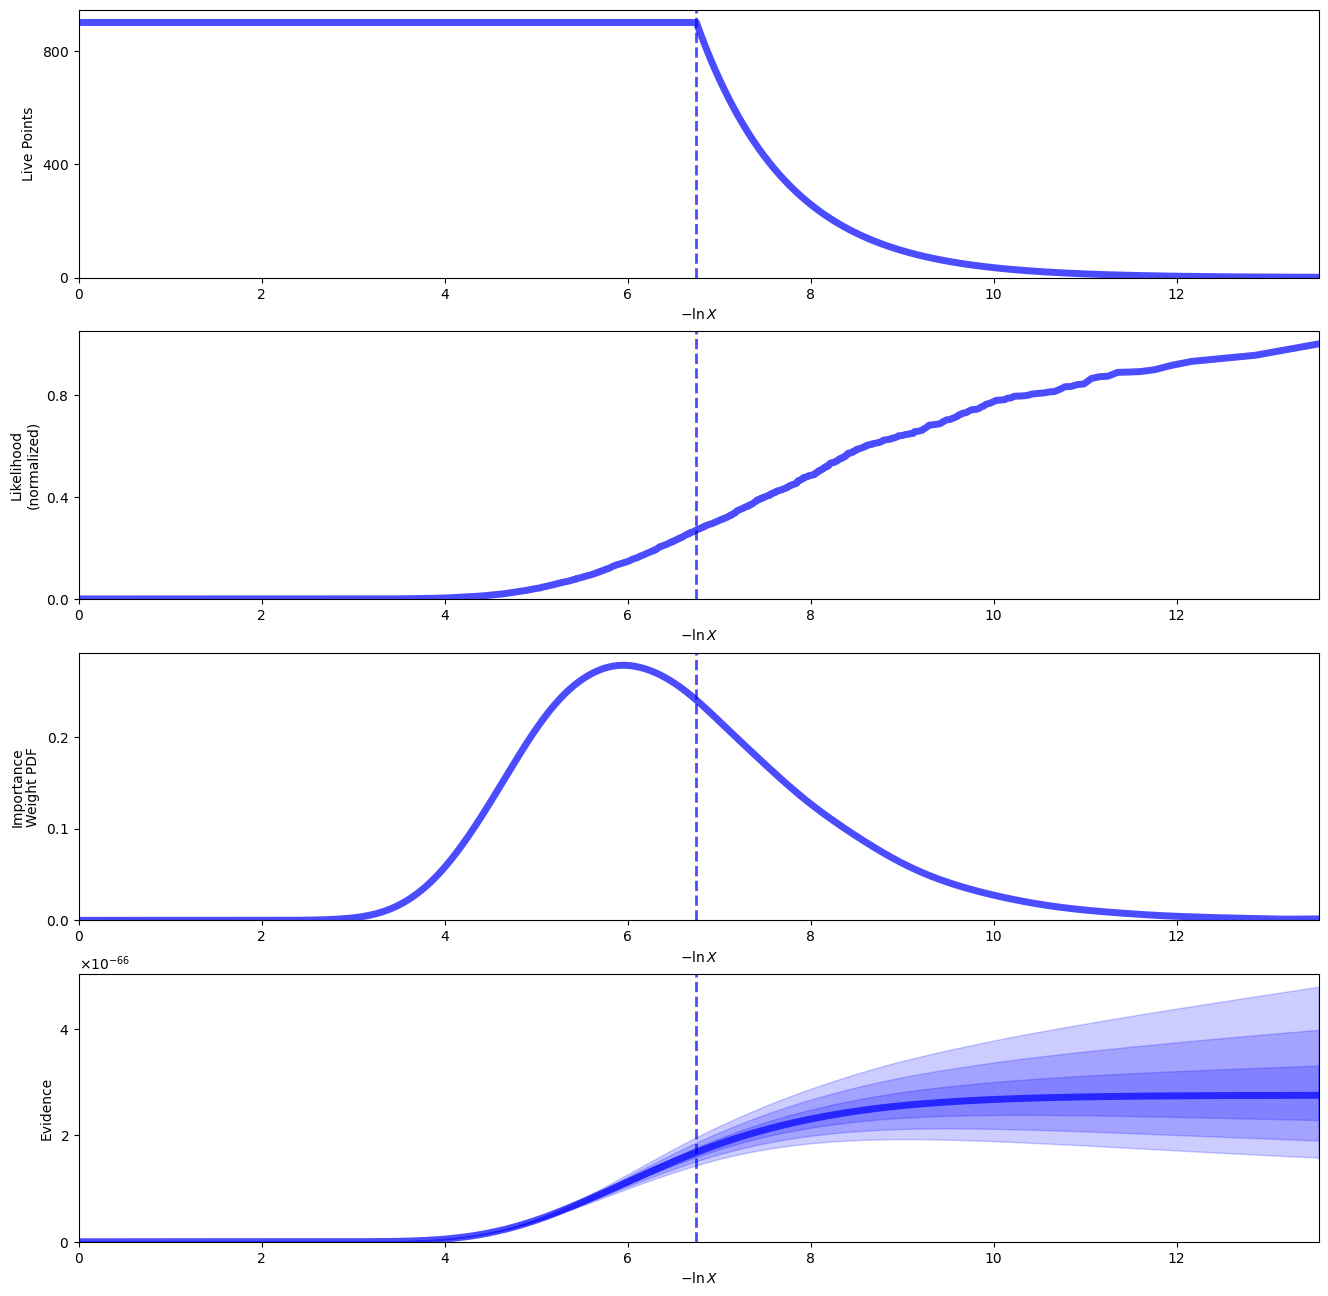

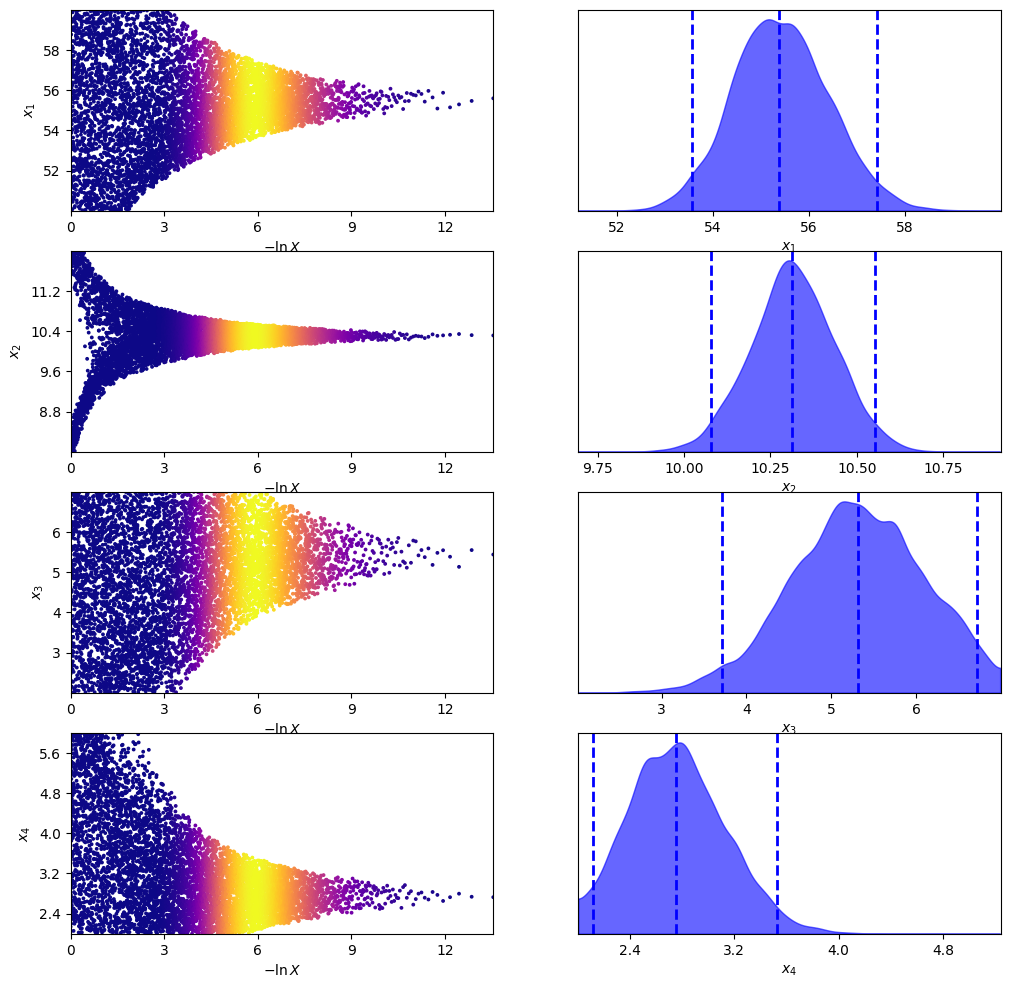

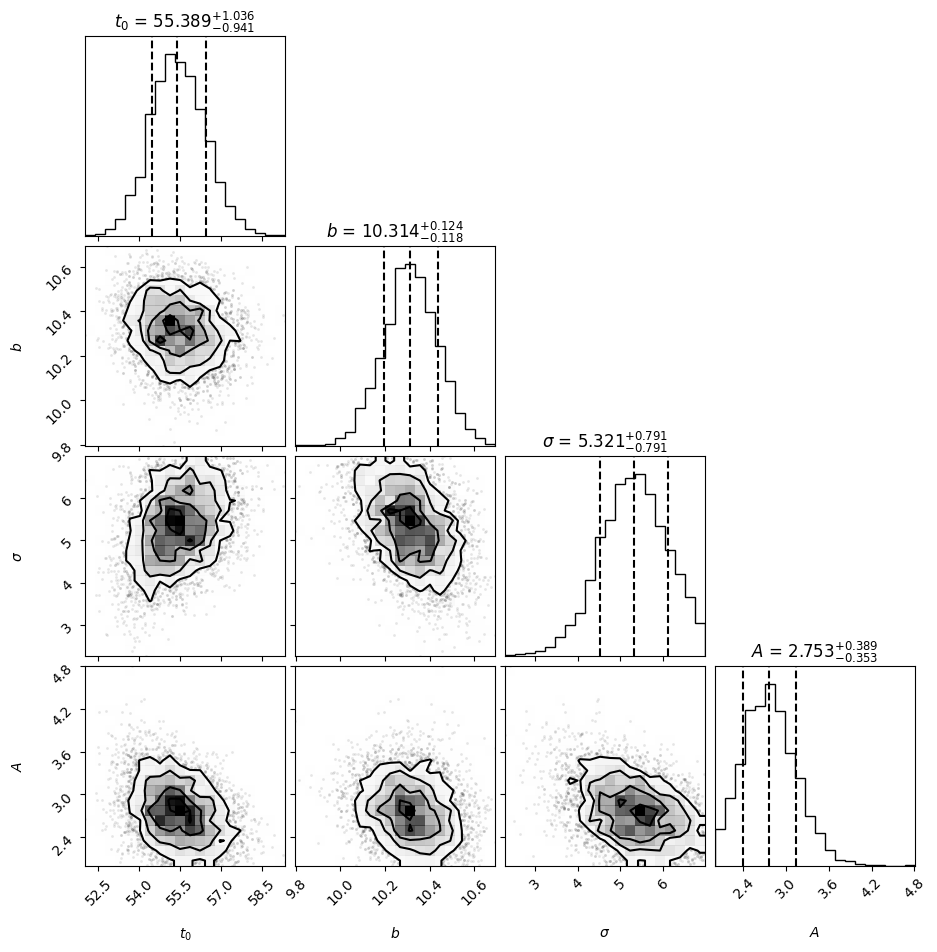

In [4]:
# >> MODEL 2
def burst2 (TIME, t0, b, sigma, A): # GAUSSIAN MODEL
    y = np.zeros(len(TIME))

    for i in range(len(TIME)):
        y[i] = b + A * np.exp(-(TIME[i]-t0)**2 / (2*sigma**2))

    return y

def LOGlikelihood2(TIME, FLUX, Sflux):
    def loglike(theta):
        t0, b, sigma, A = theta
        model = burst2(TIME, t0, b, sigma, A)
        normaliz = np.log(2 * np.pi * Sflux ** 2) # logarithmic normalization of the normal distribution
        return -0.5 * np.sum(((FLUX - model) / Sflux) ** 2 + normaliz)
    return loglike

# Estimate of the parameters of the second model -> to choose the priors
Et0 = 55
Eb = 10
EA = 4
Esigma = 4

plt.errorbar(TIME, FLUX, Sflux, capsize=3, fmt="r--o", ecolor = "grey", label = 'data')
BURST = burst2(TIME, Et0, Eb, Esigma, EA) 
plt.plot(TIME, BURST, label='Fit estimate', color='black')

plt.title("Flux of Transcient Event - estimate of gaussian model")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

# prior
def prior_transform2(u): # Best priors to obtain both convergence of parameters and fit (if sigma is too big, gaussian is flat)
    t0 = 50 + 10 * u[0]     # [50, 60] 
    b = 8 + 4 * u[1]        # [8, 12]  
    A = 2 + 4 * u[2]        # [3, 7]    
    sigma = 2 + 5 * u[3]    # [2, 7]  
    return [t0, b, sigma, A]
    
# dynesty estimates the posterior integrating the product of the prior and the log_likelihood
loglike2 = LOGlikelihood2(TIME, FLUX, Sflux) # sampling function

sampler2 = dynesty.NestedSampler(loglike2, prior_transform2, ndim=4, sample='rwalk', nlive=900, bootstrap=0) # random walk - to resolve inefficient sampling
sampler2.run_nested()

results2 = sampler2.results
rfig, raxes = dyplot.runplot(results2)
tfig, taxes = dyplot.traceplot(results2)

# normal weights -> obtain means and variances representative of the posterior distribution, not of the sampling
samples2 = results2.samples # results.samples = sampled parameters (N, ndim)
weights2 = np.exp(results2.logwt - results2.logz[-1]) # normalised weights = exp (log_weights) / exp (log_bayesian_evidence)
mean2, cov2 = dyfunc.mean_and_cov(samples2, weights2)  

print()
print("model_1")
print(f"t0 = {mean[0]} - b = {mean[1]} - alpha = {mean[2]} - A = {mean[3]}")
print("Posterior covariance: ")
print(cov)

print()
print("model_2")
print(f"t0 = {mean2[0]} - b = {mean2[1]} - sigma = {mean2[2]} - A = {mean2[3]}")
print("Posterior covariance: ")
print(cov2)

# Resampling of points to obtain same distribution and same weight
resampled2 = dyfunc.resample_equal(samples2, weights2)

# Corner plot of the 4-D parameter space, with labels, [68, 95] credible levels and quantiles, and titles
labels2 = [r"$t_0$", r"$b$", r"$\sigma$", r"$A$"]

fig = corner.corner( # CAN'T USE DIFFERENT WEIGHTS
    resampled2,
    labels=labels2,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.show()

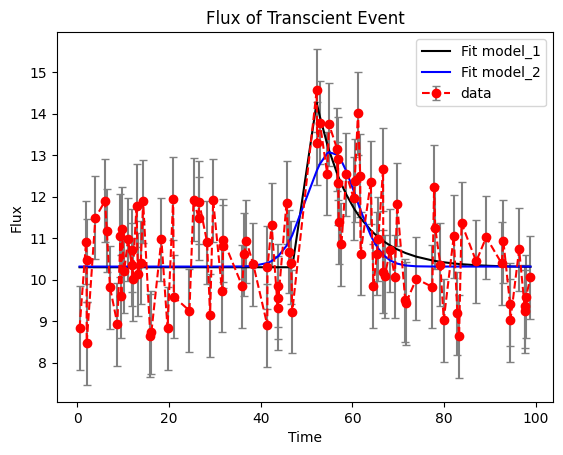


Log Evidence (Burst model):    -155.768
Log Evidence (Gaussian model): -150.958

Log Bayes Factor (Burst vs Gaussian): -4.810
GAUSSIAN MODEL IS FAVOURED !
Moderate evidence


In [5]:
# Best value - fit
plt.errorbar(TIME, FLUX, Sflux, capsize=3, fmt="r--o", ecolor = "grey", label = 'data')

t0, b, alfa, A = mean
BURST1 = burst1(TIME, t0, b, alfa, A) # Fit
plt.plot(TIME, BURST1, label='Fit model_1', color='black')

T0, B, SIGMA, AA = mean2
BURST2 = burst2(TIME, T0, B, SIGMA, AA) # Fit
plt.plot(TIME, BURST2, label='Fit model_2', color='blue')

plt.title("Flux of Transcient Event")
plt.xlabel("Time")
plt.ylabel("Flux")

plt.legend()
plt.show()

# MODELS CONFRONT 
# Log evidence 
logZ1 = results.logz[-1]     
logZ2 = results2.logz[-1]     

print()
print(f"Log Evidence (Burst model):    {logZ1:.3f}")
print(f"Log Evidence (Gaussian model): {logZ2:.3f}")
print()

# Bayesian factor = Z1 / Z2 or in Log = log(Z1) - log(Z2)
logB = logZ1 - logZ2
print(f"Log Bayes Factor (Burst vs Gaussian): {logB:.3f}")
if logB < 0: 
    print("GAUSSIAN MODEL IS FAVOURED !")
else: 
    print("BURST MODEL IS FAVOURED !")
    
if abs(logB) < 1:
    evidence = "Inconclusive"
elif abs(logB) < 2.5:
    evidence = "Weak evidence"
elif abs(logB) < 5:
    evidence = "Moderate evidence"
else:
    evidence = "Strong evidence"

print(evidence)